# Setup

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
#Adjusting path for importing data

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Folder Name'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE,'images')
print(os.listdir(GOOGLE_DRIVE_PATH))

['the_persistence_of_memory.jpg', 'starry_night.jpg', 'le_temps.jpg', 'informatics.jpg', 'portrait_of_a_lady.jpg', 'lenna.jpg']


# Style Transfering

In this part, a method will be implemented from "Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)

In [ ]:
squeezeNet_mean = torch.tensor([0.485, 0.456, 0.406])
squeezeNet_std = torch.tensor([0.229, 0.224, 0.225])

vgg_mean = torch.tensor([0.485, 0.456, 0.406])
vgg_std = torch.tensor([0.229, 0.224, 0.225])


In [ ]:
if torch.cuda.is_available:
  dtype = torch.cuda.FloatTensor
else:
  print("No Gpu will be used")
  dtype = torch.FloatTensor


In [ ]:
def preprocess(img,model_mean,model_std,size=512):
  # (1,C,H,W) or (N,C,H,W) format is chosen for all functions.
  # Because it is more appropriate to pytorch.( In terms of their functions, models ,etc.)
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=model_mean.tolist(),
                    std=model_std.tolist()),
        T.Lambda(lambda x: x[None]), # To turn from (C,H,W) format to (1,C,H,W) format
    ])
    return transform(img)

def deprocess(img,model_mean,model_std):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),# To turn from (1,C,H,W) format to (C,H,W) format
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in model_std.tolist()]),
        T.Normalize(mean=[-m for m in model_mean.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
  # It is necessary to show processed image visually better in PilImage format
  # without loosing details, or colours , etc.
    low=x.min()
    high=x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [ ]:
model_squ=torchvision.models.squeezenet1_1(weights='SqueezeNet1_1_Weights.DEFAULT').features.type(dtype)
model_vgg16=torchvision.models.vgg16('IMAGENET1K_V1').features.type(dtype)
# It gets only features according to implementation of Squeezenet in torchvision.models, does not get classification layer.
# weights trained with ImageNet will be used in first stage.

"""
model=torchvision.models.squeezenet1_1(weights='SqueezeNet1_1_Weights.DEFAULT')
with this code it takes all layers including classification part. However it is not necessary for current process.

"""
def make_nongrad(model):
  # There is no need for grad graph, model will not be trained for this process
  for param in model.parameters():
    param.requires_grad=False
  return model

model_squ=make_nongrad(model_squ)
model_vgg16=make_nongrad(model_vgg16)





In [ ]:
def get_features(x,model):
  """
  Inputs:
  - x: A pytorch tensor including minibatches of image. It will be fed to CNN model
  - model: A model used to extract features
  Outputs:
  - features: Feature list holding all weights (features). For example, features[1]
  holds weights of first layer for total batch of images(N,Ci,Hi,Wi).
  For our case, generally it will be as (1,C,H,W).
  """
  prev_feature=x
  features=[]
  for module in model._modules.values():
    next_feature=module(prev_feature)
    features.append(next_feature)
    prev_feature=next_feature

  return features



## Content Loss

In [ ]:
def content_loss(cont_source,cont_generated,cont_weight):
  """
  This function calculates content loss.
  Inputs:
  - cont_source: features of source image with tensor shape (N,Cl,Hl,Wl)
  In this case, there is one image so N=1. Therefore, shape is (1,Cl,Hl,Wl)
  - cont_generated: features of generated image with tensor shape (N,Cl,Hl,Wl)
  In this case, there is one image so N=1. Therefore, shape is (1,Cl,Hl,Wl)
  - cont_weight: a scalar determining contribuiton of content image to total loss
  In article and report, this variable is showed at final total loss formula
  as alpha. For implementation, it is decided that alpha and loss multiplication
  should in this function for better readability.

  Outputs:
  - scalar_content_loss: calculated content loss as scalar.
  """
  F_s=cont_generated.shape
  F=torch.reshape(cont_generated,(F_s[1],F_s[2]*F_s[3]))
  # (1,C,H,W) to (1,C,M) for M=H*W
  P_s=cont_source.shape
  P=torch.reshape(cont_source,(P_s[1],P_s[2]*P_s[3]))
  # (1,C,H,W) to (1,C,M) for M=H*W
  scalar_content_loss=cont_weight*torch.sum((F-P)**2)
  return scalar_content_loss

## Style Loss

In [ ]:
def form_gram_matrix(feats,normalize=True):
  """
  This function forms a gram matrix.
  Inputs:
  - feats: features for N batch images. It is a tensor whose shape is (N,C,H,W)
  - normalize: normalizing gram matrix. If it is True, it will be divided to
  (C,H,W). In the article or project report, this normalization process
  can be seen at final style loss formula. In this implementation,
  it will be managed by giving normalized gram matrix as output.
  Their squares will be equalivent to formula.

  Outputs:
  - gram: Optionally normalized gram matrix
  """
  N,C,H,W=feats.shape
  F=feats.reshape((N,C,H*W))
  gram=F.matmul(F.transpose(1,2))
  return gram/(H*W*C) if normalize else gram

In [ ]:
def style_loss(feats,style_layers,style_targets,style_weights):
  """
  This function calculates style loss.
  Inputs:
  - feats: features for N batch images. It is a tensor whose shape is (N,C,H,W)
  - style_layers: List of indices of layers into features.
  These layers are selected to contribute style loss.
  - style_targets: It is a list which stores Gram matrices of source style image
  calculated at layer style_layers. It has same length with style_layers.
  To illustrate, style_targets [i] is a gram matrice for style_layers[i].
  - style_weights: Style weights of each layer as list for determining
  contribution to style loss. For example, style_weights[i] is correspond to
  style_layers[i]

  Outputs:
  - style_loss: A pytorch tensor which stores style loss as scalar value.
  """

  style_loss=0
  for i in range(len(style_layers)):
    gram=form_gram_matrix(feats[style_layers[i]])
    style_loss+=style_weights[i]*torch.sum((gram-style_targets[i])**2)
  return style_loss


In [ ]:
def style_transfer(model,cont_image_path, style_image_path, image_size, style_size, cont_layer, cont_weight,
                   style_layers, style_weights,initial_lr,model_mean,model_std,dtype):


  # Obtaining content image features
  cont_img=PIL.Image.open(cont_image_path)
  cont_img=preprocess(cont_img,model_mean,model_std,image_size).type(dtype)
  features=get_features(cont_img,model)
  cont_target=features[cont_layer].clone()

  # Obtaining style image features
  style_img=PIL.Image.open(style_image_path)
  style_img=preprocess(style_img,model_mean,model_std,style_size).type(dtype)
  features=get_features(style_img,model)
  style_targets=[]

  for i in style_layers:
    style_targets.append(form_gram_matrix(features[i].clone()))

  image=cont_img.clone().type(dtype)
  # For style trasnferring, gradient can be calculated for image
  image.requires_grad_()

  #initial_lr=3.2
  decayed_lr=0.1
  decay_lr_at=280
  optimizer = torch.optim.Adam([image], lr=initial_lr)

  f, axarr = plt.subplots(1,2)
  axarr[0].axis('off')
  axarr[1].axis('off')
  axarr[0].set_title('Content Image.')
  axarr[1].set_title('Style Image.')
  axarr[0].imshow(deprocess(cont_img.cpu(),model_mean,model_std))
  axarr[1].imshow(deprocess(style_img.cpu(),model_mean,model_std))
  plt.show()
  plt.figure()


  for iter in range(300):
    if iter < 280:
            image.data.clamp_(-1.5, 1.5)
    optimizer.zero_grad()

    feats = get_features(image, model)

    # Compute loss
    c_loss = content_loss(feats[cont_layer], cont_target , cont_weight)
    s_loss = style_loss(feats, style_layers, style_targets, style_weights)
    loss = c_loss + s_loss

    loss.backward()

    # Perform gradient descents on our image values
    if iter == decay_lr_at:
      optimizer = torch.optim.Adam([image], lr=decayed_lr)
    optimizer.step()

    if iter % 100 == 0:
      print('Iteration {}'.format(iter))
      plt.axis('off')
      plt.imshow(deprocess(image.data.cpu(),model_mean,model_std))
      plt.show()

  print('Iteration {}'.format(iter))
  plt.axis('off')
  plt.imshow(deprocess(image.data.cpu(),model_mean,model_std))
  plt.show()




# Obtaining Images

In [ ]:
"""
-----------Picture names--------------

Informatics Institute
-informatics.jpg

Lenna Forsen
-lenna.jpg

By Rogier Van Der Weyden
-portrait_of_a_lady.jpg

By Van Gogh
-starry_night.jpg

By Salvador Dali
-the_persistence_of_memory.jpg

"""



'\n-----------Picture names--------------\n\nInformatics Institute\n-informatics.jpg\n\nLenna Forsen\n-lenna.jpg\n\nBy Rogier Van Der Weyden\n-portrait_of_a_lady.jpg\n\nBy Van Gogh\n-starry_night.jpg\n\nBy Salvador Dali\n-the_persistence_of_memory.jpg\n\n'

In [ ]:
print(model_squ) # For looking convolution layers corresponds to which index.



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (3): Fire(
    (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (4): Fire(
    (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (squeeze_activation): ReLU(inplace=True)
    (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (expand1x1_activation): ReLU(inplace=True)
    (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (expand3x3_activation): ReLU(inplace=True)
  )
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
 

In [ ]:
print(model_vgg16) # For looking convolution layers corresponds to which index.

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

## Example Pictures

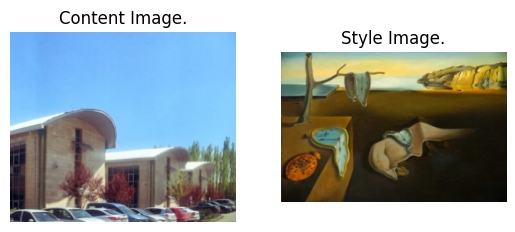

Iteration 0


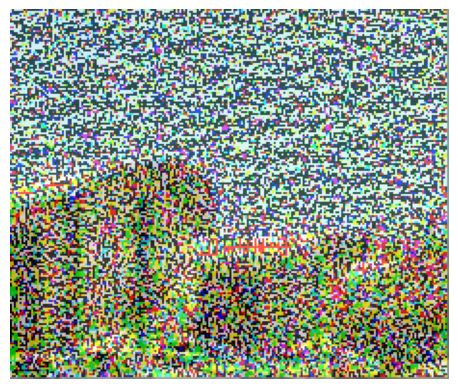

Iteration 100


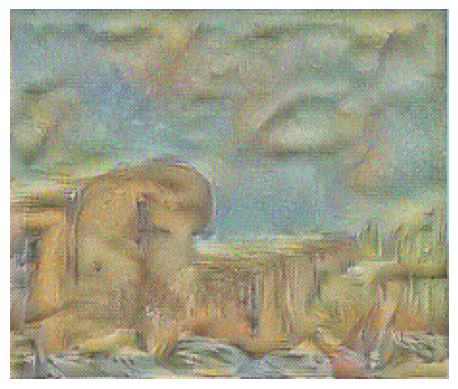

Iteration 200


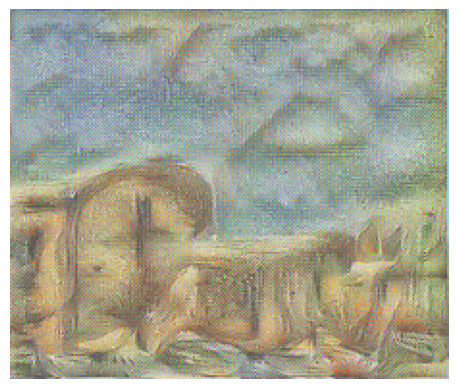

Iteration 299


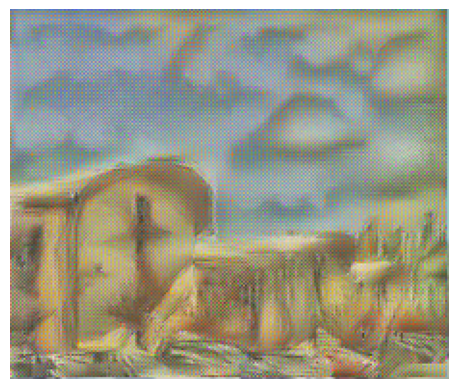

In [ ]:
params1 = {
    'model':model_squ,
    'cont_image_path' : os.path.join(GOOGLE_DRIVE_PATH ,'informatics.jpg'),
    'style_image_path' : os.path.join(GOOGLE_DRIVE_PATH,'the_persistence_of_memory.jpg'),
    'image_size' : 192,
    'style_size' : 192,
    'cont_layer' : 3,
    'cont_weight' : 5e-2,
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (25000, 800, 40, 5),
    'initial_lr':3.2,
    'model_mean':squeezeNet_mean,
    'model_std' :squeezeNet_std,
    'dtype': dtype
}

style_transfer(**params1)

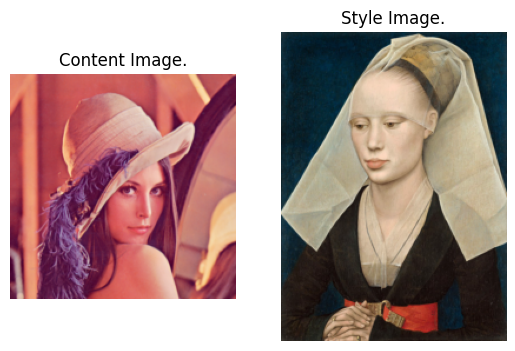

Iteration 0


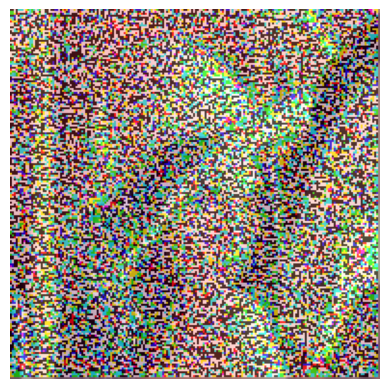

Iteration 100


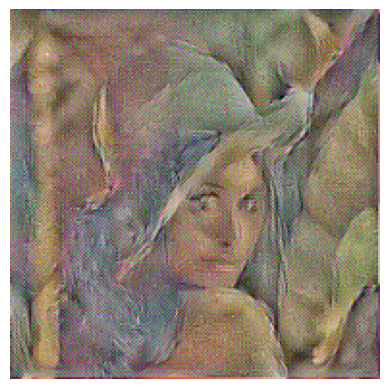

Iteration 200


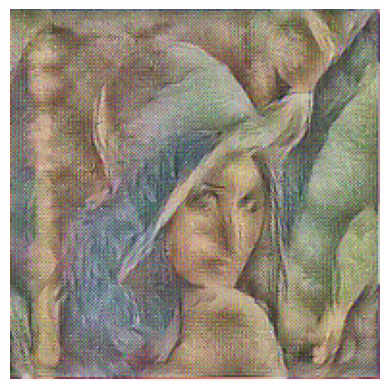

Iteration 299


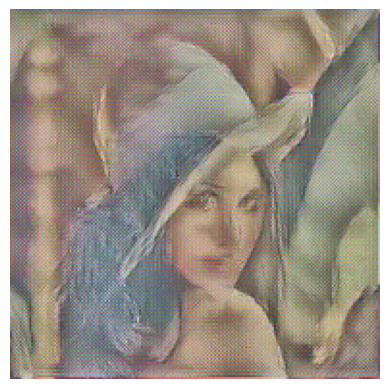

In [ ]:
params1 = {
    'model':model_squ,
    'cont_image_path' : os.path.join(GOOGLE_DRIVE_PATH ,'lenna.jpg'),
    'style_image_path' : os.path.join(GOOGLE_DRIVE_PATH,'portrait_of_a_lady.jpg'),
    'image_size' : 192,
    'style_size' : 192,
    'cont_layer' : 3,
    'cont_weight' : 5e-2,
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (25000, 800, 40, 5),
    'initial_lr':3.2,
    'model_mean':squeezeNet_mean,
    'model_std' :squeezeNet_std,
    'dtype': dtype
}

style_transfer(**params1)


